# Compute S

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=10, processes=10, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.119:8787/status,
Dashboard: http://10.148.0.119:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.119:37660,Workers: 0
Dashboard: http://10.148.0.119:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
DL =100*1e3 #meters
DT = 3*3600 #seconds

In [4]:
def global_ms_drifter_sat_year(dsms):
    ds = (((dsms*dsms.nb_coloc).sum('drifter_sat_year'))/(dsms.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    for v in dsms.keys():
        if v != 'nb_coloc':
            ds[v].attrs=dsms[v].attrs
    return ds

In [5]:
def plot_closure_bar(ds, id_, ax, title=1):
    """ Plot closure bars for a combination on the axis ax.
    
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']

    # ACC X
    ax.bar(1.5, (np.sqrt(ds[acc]) + np.sqrt(ds['exc_acc_' + id_]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, (np.sqrt(ds[acc]) - np.sqrt(ds['exc_acc_' + id_]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, ds['exc_acc_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds[acc], bottom = ds['exc_acc_' + id_],
           color = 'red', width = 0.4, zorder=3, align = 'center')

    # CORIOLIS
    ax.bar(2, (np.sqrt(ds['exc_coriolis_' + id_]) + np.sqrt(ds[cor]))**2,
           color='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2, (np.sqrt(ds['exc_coriolis_' + id_]) - np.sqrt(ds[cor]))**2,
           color='w', width = 0.45, zorder=3, align = 'center', )
    ax.bar(2, ds['exc_coriolis_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds[cor], bottom = ds['exc_coriolis_' + id_],
           color = 'green', width = 0.4, zorder=3, align = 'center')

    # G GRADIENT SLA
    ax.bar(2.5, (np.sqrt(ds['exc_ggrad_' + id_]) + np.sqrt(ds[ggrad]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, (np.sqrt(ds['exc_ggrad_' + id_]) - np.sqrt(ds[ggrad]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, ds['exc_ggrad_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds[ggrad], bottom = ds['exc_ggrad_' + id_],
           color = 'c', width = 0.4, zorder=3, align = 'center')

    # WIND
    ax.bar(3, (np.sqrt(ds['exc_wind_' + id_]) + np.sqrt(ds[wd]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, (np.sqrt(ds['exc_wind_' + id_]) - np.sqrt(ds[wd]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, ds['exc_wind_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds[wd], bottom = ds['exc_wind_' + id_],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    
    #SUM of ms^2
    ax.bar(1,ds[acc],
           color = 'red', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[cor], bottom = ds[acc],
           color = 'green', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[ggrad], bottom = ds[acc]+ds[cor],
           color = 'c', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[wd], bottom = ds[acc]+ds[cor]+ds[ggrad],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    Ss=ds[acc]+ds[cor]+ds[ggrad]+ds[wd]
    ax.text(0.75, Ss+Ss/30, str(np.format_float_scientific(Ss.values,precision = 3)))

    ax.set_ylabel(r'Mean square $\langle ...^2 \rangle$ [$m^2/s^4$]')
    if isinstance(title, int): ax.set_title(id_)
    else : ax.set_title(title+'\n'+id_+'\n')
    
    #TOTAL
    S = ds['sum_'+id_]
    ax.bar(0.5, S, color ='k',width = 0.4, zorder=3)
    ax.text(0.25, S+S/20, str(np.format_float_scientific(S.values,precision = 3)))
    ax.axhline(y=S, c="k", linewidth=2, ls=':', zorder=4)
    
    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)
    
    N=np.arange(0.5,3.5, 0.5) 
    #g = ds[ggrad].attrs['long_name'].replace('rms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso').split('+')
    #ggrad_tick='$\n $+'.join(g)
    #w = ds_all['rms_es_cstrio_z15_alti_wd_x'].attrs['long_name'].replace('rms[',r'').replace(']','').split(' from')
    #wd_tick = '\n from'.join(w)
    #ticks = (r'$\langle S^2\rangle$',r'$\sum_x \langle x^2\rangle$',r'$d_tu$', r'$-fv$', ggrad_tick, r'$\frac{1}{\rho}\partial_z\tau_x$')
    #ax.set_xticks(N, ticks,)

    print(f'acc:{ds[acc].values}, coriolis:{ds[cor].values}, ggrad:{ds[ggrad].values}, wind:{ds[wd].values}')

In [6]:
def RSE_id(ds, id_):
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']
    return (ds['sum_'+id_]/(ds[acc]+ds[cor]+ds[ggrad]+ds[wd])).values*100
def RSE_df(ds):
    RSE = []
    for id_ in ds.id_comb.values:
        RSE.append(RSE_id(ds, id_))
    return pd.DataFrame({'id_comb':ds.id_comb, 'RSE':RSE}).set_index('id_comb')

_____
# All

In [7]:
ds = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'ms_{DL//1000}_{DT}.zarr')).persist()
ds['drifter_sat_year'] = labels
ds_ = global_ms_drifter_sat_year(ds)

In [8]:
RSE = RSE_df(ds_)
min_aviso = RSE.loc[[l for l in list(RSE.index) if 'aviso' in l]].RSE.idxmin()
min_co = RSE.loc[[l for l in list(RSE.index) if 'co' in l]].RSE.idxmin()
RSE['color']='teal'
RSE.color.loc[min_aviso]='r'
RSE.color.loc[min_co]='salmon'

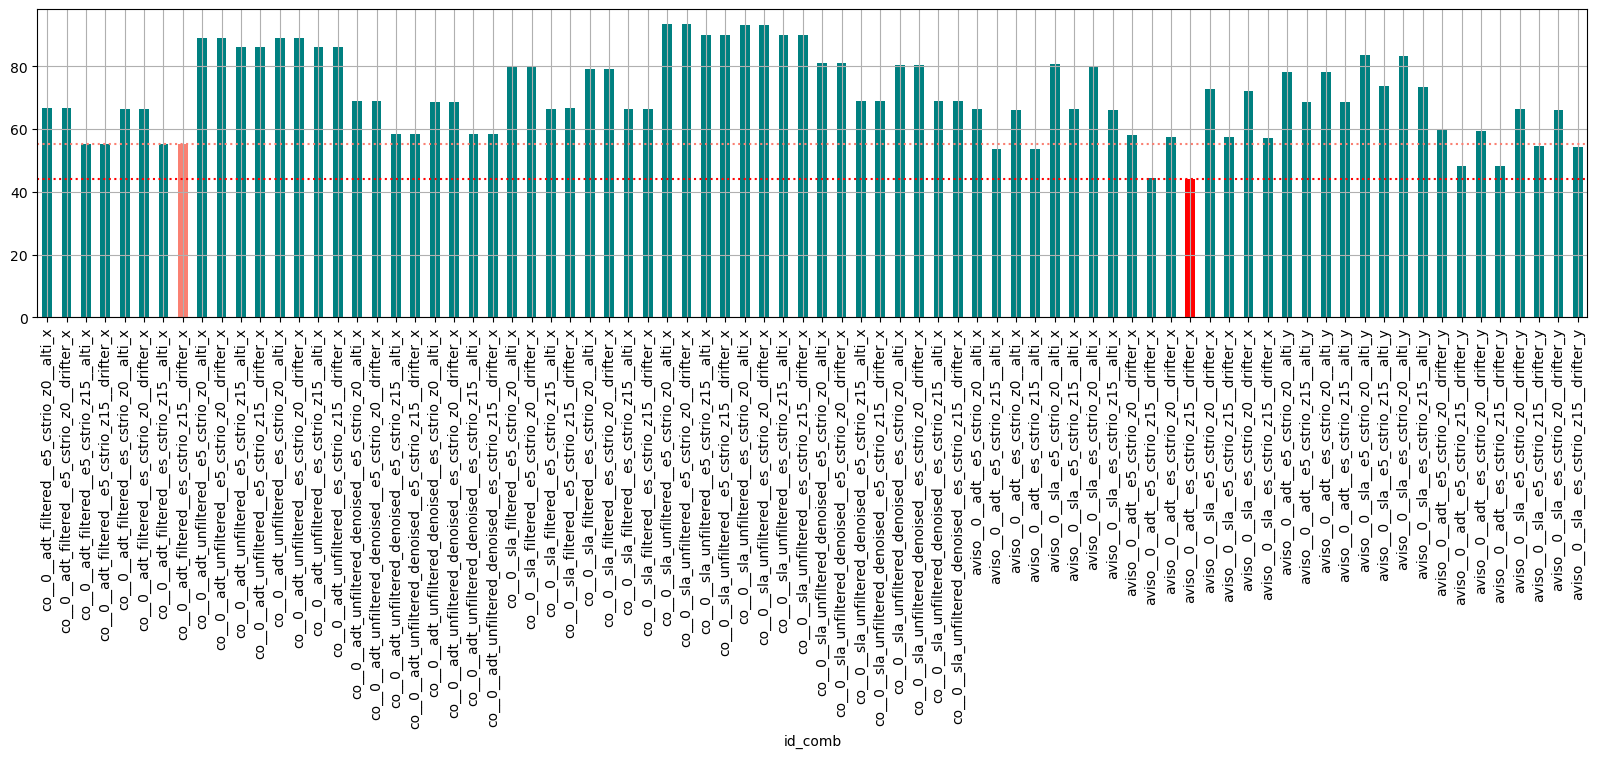

In [10]:
fig = plt.figure(figsize=(20,4))
RSE.RSE.plot.bar(color=RSE.color)
plt.axhline(RSE.RSE.loc[min_aviso], color='red', ls=':')
plt.axhline(RSE.RSE.loc[min_co], color='salmon', ls=':')
plt.grid()

acc:2.0769604596864347e-10, coriolis:4.6302650737158895e-10, ggrad:1.694461440146954e-10, wind:1.5555951449092082e-11
acc:2.0769604596864347e-10, coriolis:4.6302650737158895e-10, ggrad:2.655725471594855e-10, wind:1.5555951449092082e-11


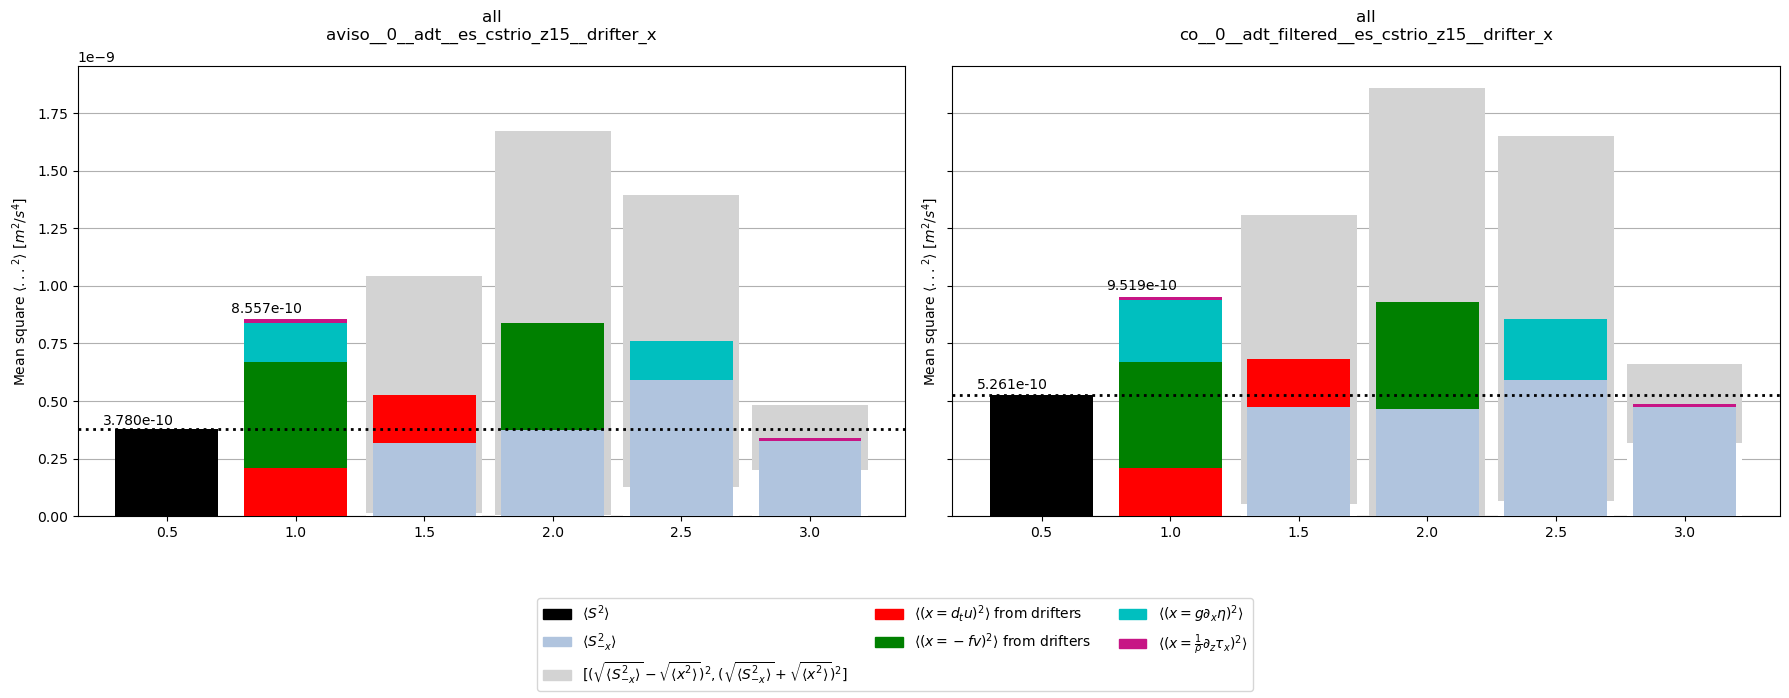

In [11]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(ds_, min_aviso,axs[0], title = 'all')
plot_closure_bar(ds_, min_co ,axs[1], title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# All gps

In [12]:
gps = [l for l in labels if 'gps' in l]
ds_gps = global_ms_drifter_sat_year(ds.sel(drifter_sat_year=gps))

In [13]:
RSE_gps = RSE_df(ds_gps)
min_aviso_gps = RSE_gps.loc[[l for l in list(RSE.index) if 'aviso' in l]].RSE.idxmin()
min_co_gps = RSE_gps.loc[[l for l in list(RSE.index) if 'co' in l]].RSE.idxmin()
RSE_gps['color']='teal'
RSE_gps.color.loc[min_aviso_gps]='r'
RSE_gps.color.loc[min_co_gps]='salmon'

38.30947834949034 51.5386969410373


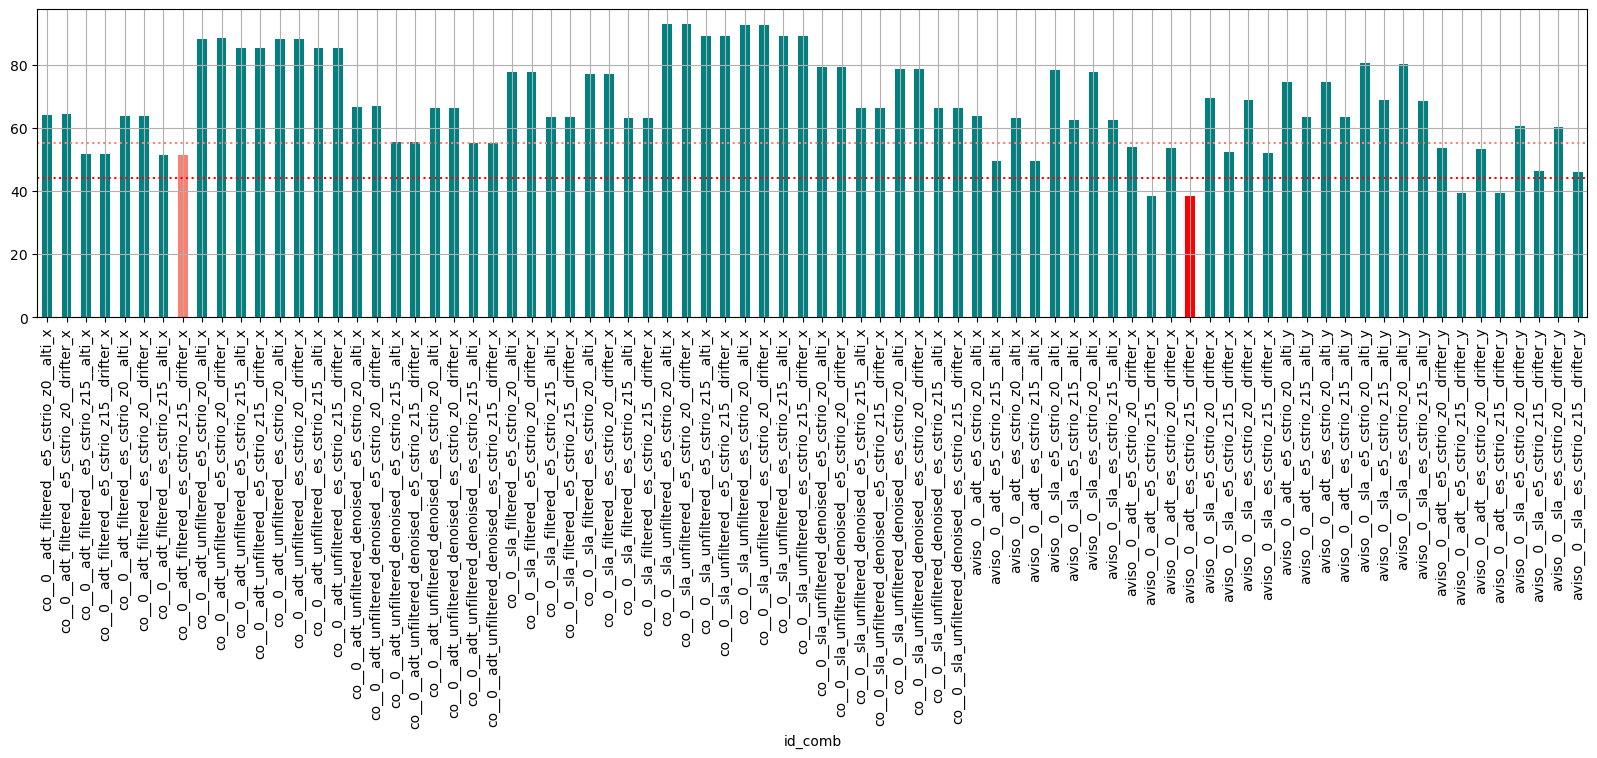

In [16]:
fig = plt.figure(figsize=(20,4))
RSE_gps.RSE.plot.bar(color=RSE.color)
plt.axhline(RSE.RSE.loc[min_aviso], color='red', ls=':')
plt.axhline(RSE.RSE.loc[min_co], color='salmon', ls=':')
plt.grid()
print(RSE_gps.RSE.loc[min_aviso_gps], RSE_gps.RSE.loc[min_co_gps])

acc:1.5164207077627418e-10, coriolis:4.4928348592421524e-10, ggrad:1.7162477942888237e-10, wind:1.7924664508465142e-11
acc:1.5164207077627418e-10, coriolis:4.4928348592421524e-10, ggrad:2.669494744175665e-10, wind:1.7924664508465142e-11


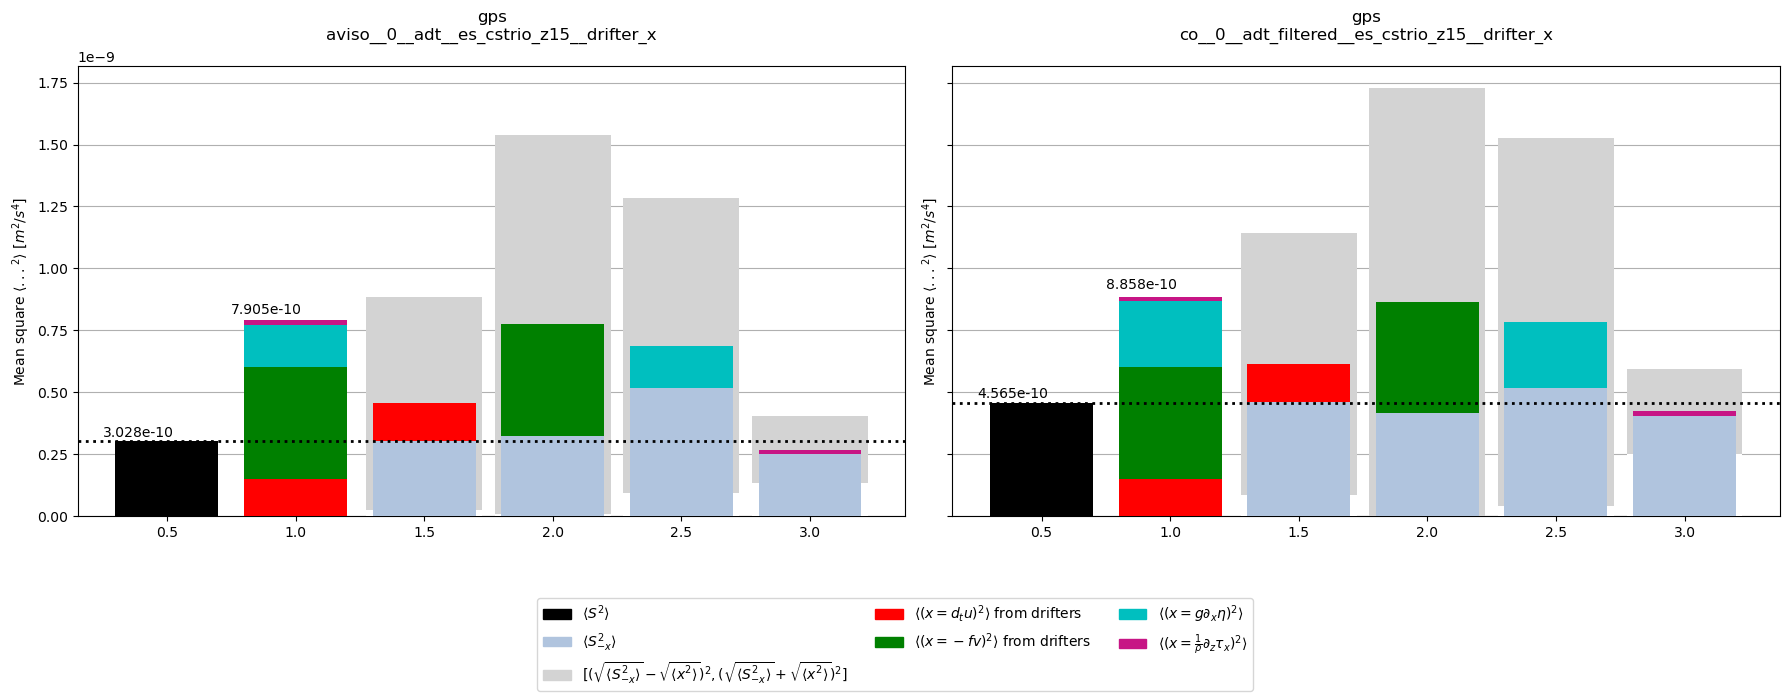

In [17]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(ds_gps, min_aviso_gps,axs[0], title = 'gps')
plot_closure_bar(ds_gps, min_co_gps ,axs[1], title = 'gps')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# All argos

In [18]:
argos = [l for l in labels if 'argos' in l]
ds_argos = global_ms_drifter_sat_year(ds.sel(drifter_sat_year=argos))

In [19]:
RSE_argos = RSE_df(ds_argos)
min_aviso_argos = RSE_argos.loc[[l for l in list(RSE.index) if 'aviso' in l]].RSE.idxmin()
min_co_argos = RSE_argos.loc[[l for l in list(RSE.index) if 'co' in l]].RSE.idxmin()
RSE_argos['color']='teal'
RSE_argos.color.loc[min_aviso_argos]='r'
RSE_argos.color.loc[min_co_argos]='salmon'

50.10956137995554 59.095924666989475


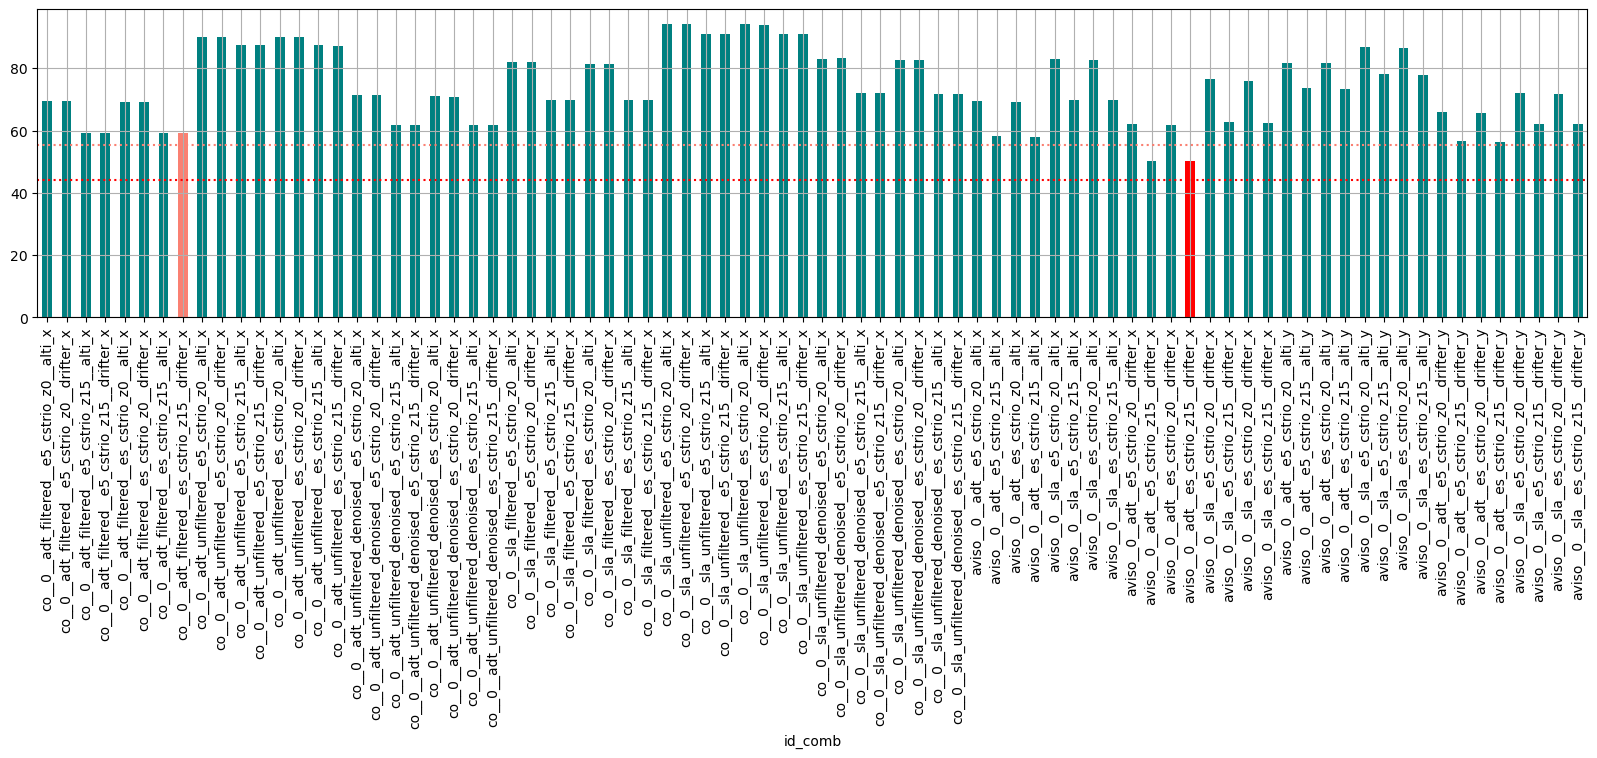

In [21]:
fig = plt.figure(figsize=(20,4))
RSE_argos.RSE.plot.bar(color=RSE.color)
plt.axhline(RSE.RSE.loc[min_aviso], color='red', ls=':')
plt.axhline(RSE.RSE.loc[min_co], color='salmon', ls=':')
plt.grid()
print(RSE_argos.RSE.loc[min_aviso_argos], RSE_argos.RSE.loc[min_co_argos])

acc:2.7466700677080157e-10, coriolis:4.79446098444241e-10, ggrad:1.6684320093304986e-10, wind:1.2725911493737972e-11
acc:2.7466700677080157e-10, coriolis:4.79446098444241e-10, ggrad:2.639274516758574e-10, wind:1.2725911493737972e-11


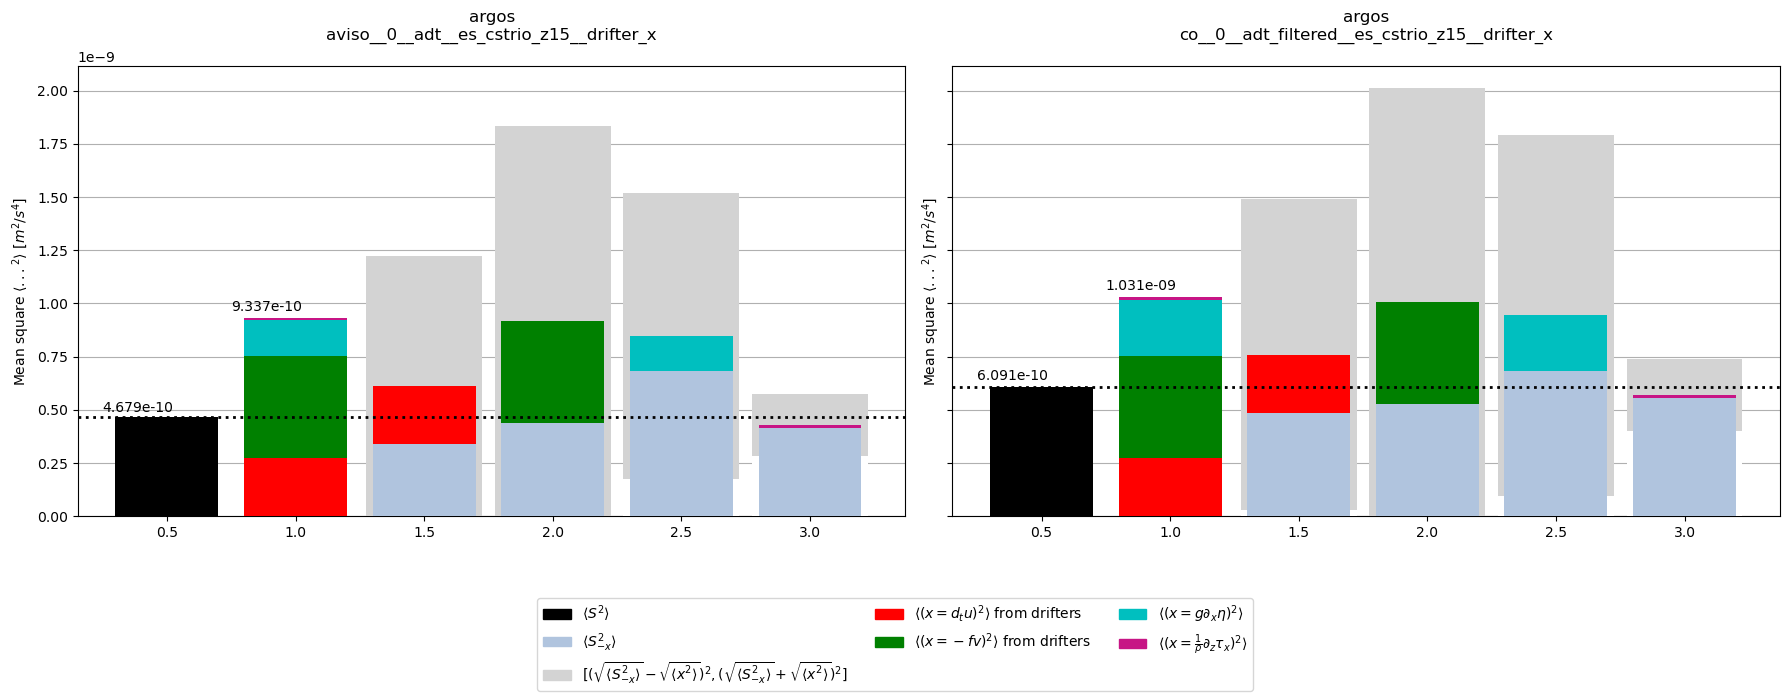

In [22]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(ds_argos, min_aviso_argos,axs[0], title = 'argos')
plot_closure_bar(ds_argos, min_co_argos ,axs[1], title = 'argos')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# All drogued

In [23]:
dsd = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'ms_{DL//1000}_{DT}_drogued.zarr')).persist()
dsd_ = global_ms_drifter_sat_year(dsd)

In [24]:
RSEd = RSE_df(dsd_)
min_avisod = RSEd.loc[[l for l in list(RSEd.index) if 'aviso' in l]].RSE.idxmin()
min_cod = RSEd.loc[[l for l in list(RSEd.index) if 'co' in l]].RSE.idxmin()
RSEd['color']='teal'
RSEd.color.loc[min_aviso]='r'
RSEd.color.loc[min_co]='salmon'

35.16998319432159 49.8602078832139


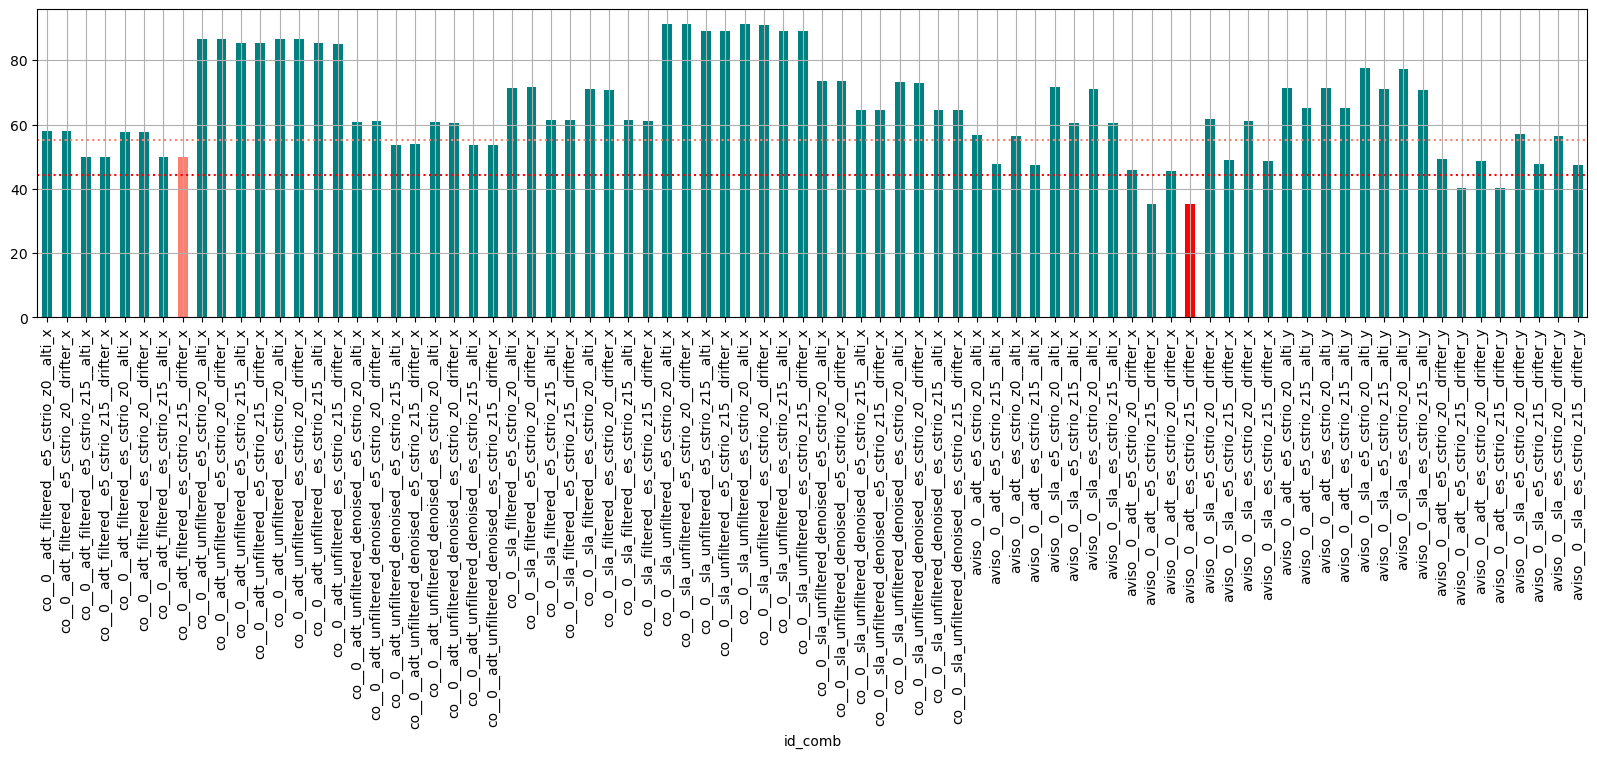

In [25]:
fig = plt.figure(figsize=(20,4))
RSEd.RSE.plot.bar(color=RSEd.color)
plt.axhline(RSE.RSE.loc[min_aviso], color='red', ls=':')
plt.axhline(RSE.RSE.loc[min_co], color='salmon', ls=':')
plt.grid()
print(RSEd.RSE.loc[min_avisod], RSEd.RSE.loc[min_cod])

acc:1.8488600014677287e-10, coriolis:3.868522733285593e-10, ggrad:1.8693928962615145e-10, wind:1.6407336377879063e-11
acc:1.8488600014677287e-10, coriolis:3.868522733285593e-10, ggrad:2.891747327684424e-10, wind:1.6407336377879063e-11


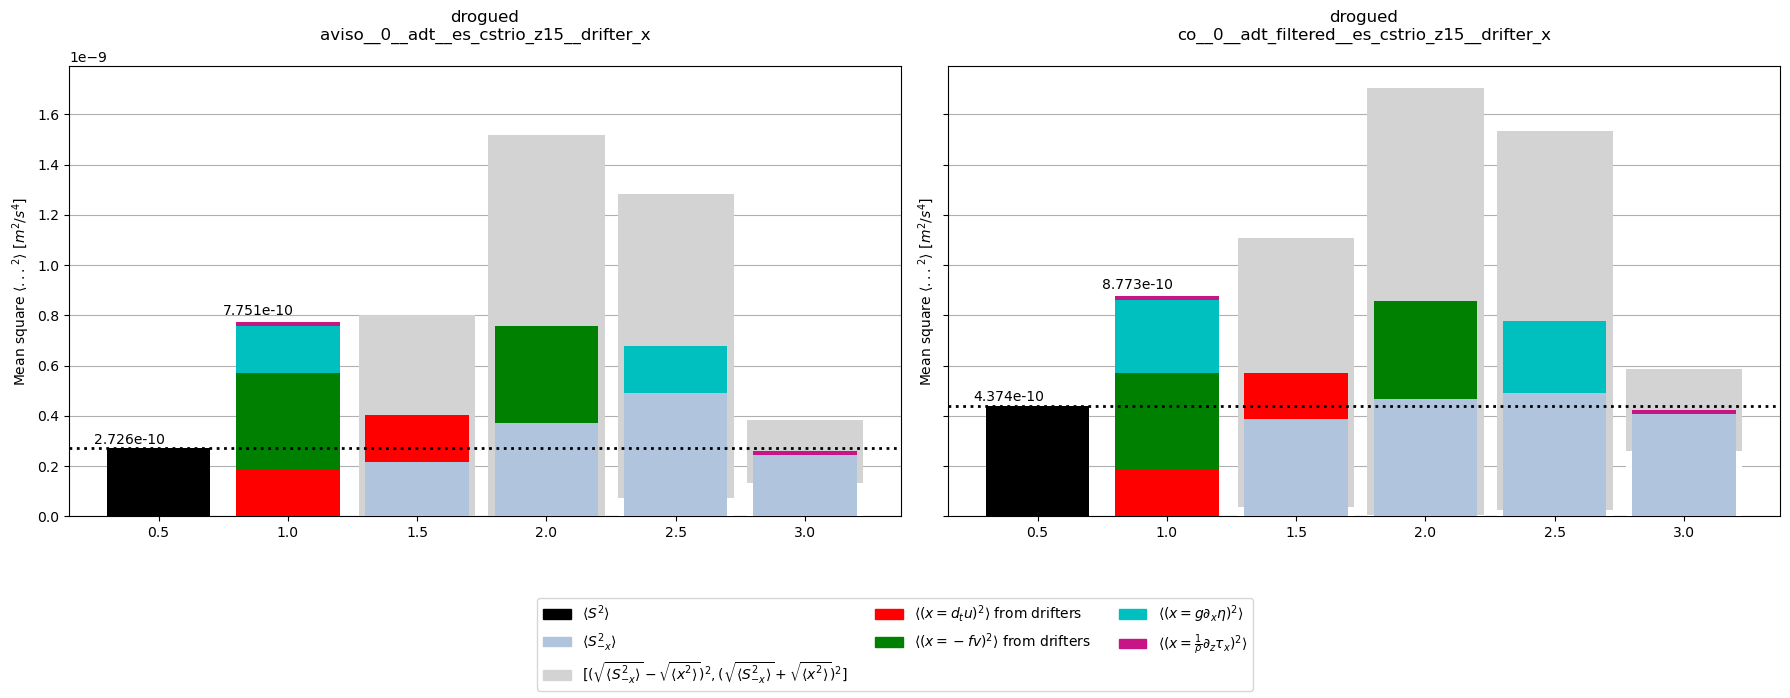

In [26]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(dsd_, min_avisod,axs[0], title = 'drogued')
plot_closure_bar(dsd_, min_cod ,axs[1], title = 'drogued')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# Drogued &gps

In [27]:
gps = [l for l in dsd.drifter_sat_year.values if 'gps' in l]
dsd_gps = global_ms_drifter_sat_year(dsd.sel(drifter_sat_year=gps))


In [28]:
RSEd_gps = RSE_df(dsd_gps)
min_avisod_gps = RSEd_gps.loc[[l for l in list(RSEd_gps.index) if 'aviso' in l]].RSE.idxmin()
min_cod_gps = RSEd_gps.loc[[l for l in list(RSEd_gps.index) if 'co' in l]].RSE.idxmin()
RSEd_gps['color']='teal'
RSEd_gps.color.loc[min_avisod_gps]='r'
RSEd_gps.color.loc[min_cod_gps]='salmon'

30.48897291905741 46.78184864362026


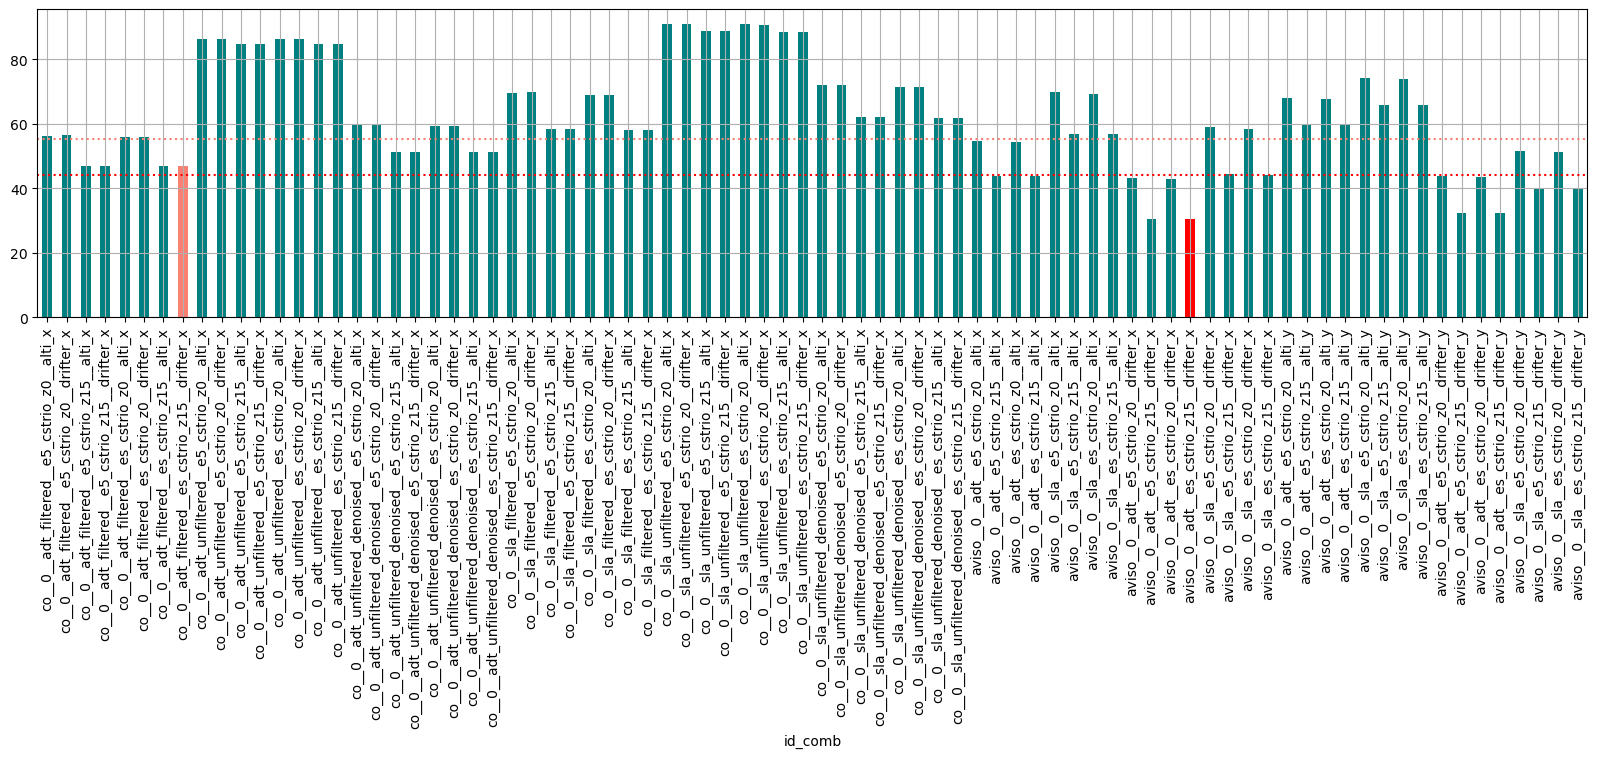

In [37]:
fig = plt.figure(figsize=(20,4))
RSEd_gps.RSE.plot.bar(color=RSEd_gps.color)
plt.axhline(RSE.RSE.loc[min_aviso], color='red', ls=':')
plt.axhline(RSE.RSE.loc[min_co], color='salmon', ls=':')
plt.grid()
print(RSEd_gps.RSE.loc[min_avisod], RSEd_gps.RSE.loc[min_cod])

acc:1.4146065069516568e-10, coriolis:3.730268315019987e-10, ggrad:1.8011328969622654e-10, wind:1.8053452017610314e-11
acc:1.4146065069516568e-10, coriolis:3.730268315019987e-10, ggrad:2.7947198645710157e-10, wind:1.8053452017610314e-11


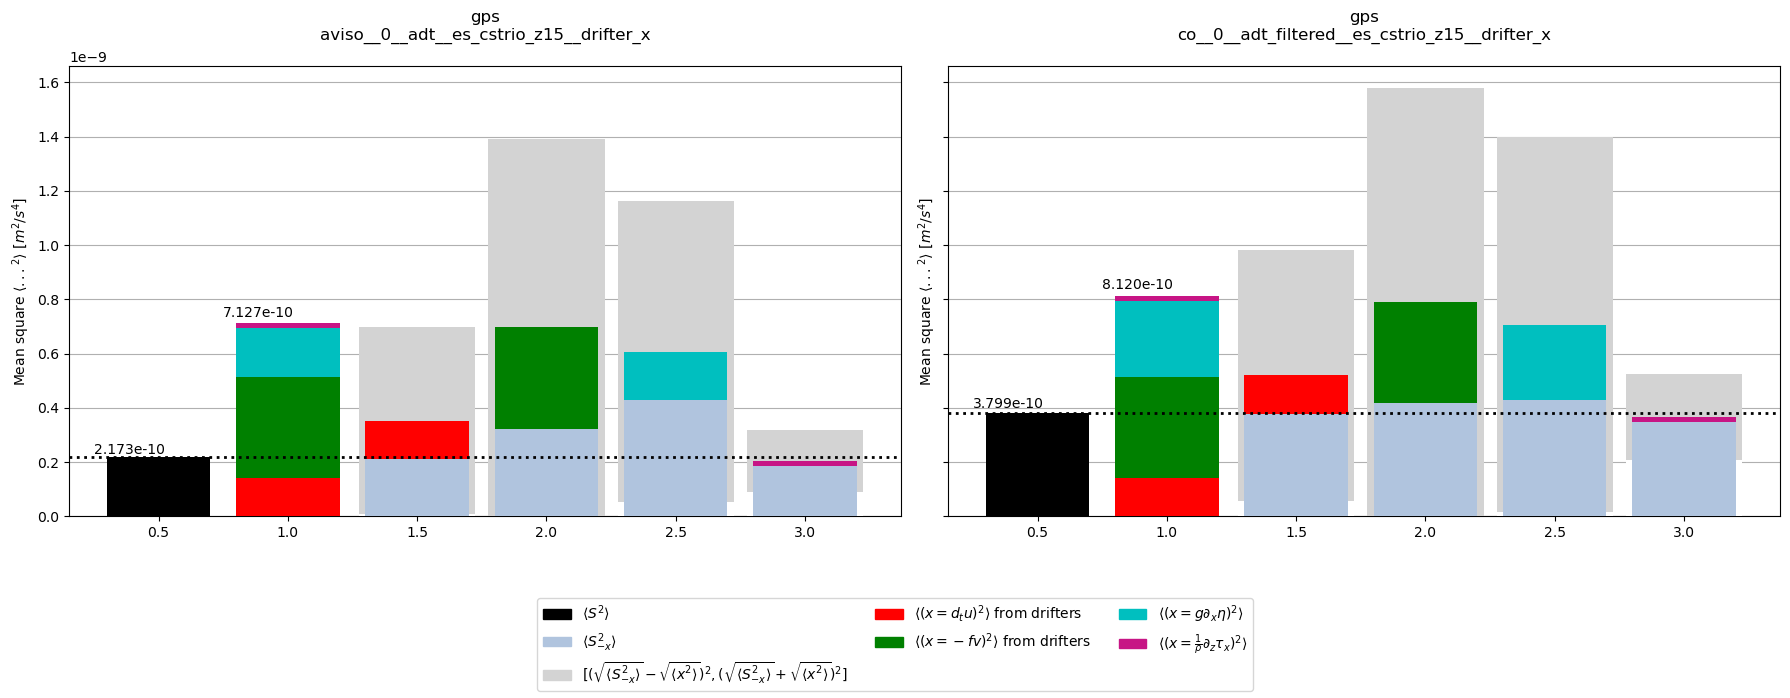

In [31]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(dsd_gps, min_avisod_gps,axs[0], title = 'gps')
plot_closure_bar(dsd_gps, min_cod_gps ,axs[1], title = 'gps')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# Undrogued & gps

In [32]:
dsu = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'ms_{DL//1000}_{DT}_undrogued.zarr')).persist()
dsu_ = global_ms_drifter_sat_year(dsu)

In [33]:
gps = [l for l in dsu.drifter_sat_year.values if 'gps' in l]
dsu_gps = global_ms_drifter_sat_year(dsu.sel(drifter_sat_year=gps))


In [40]:
dsu_gps

<xarray.Dataset>
Dimensions:                                                                (
                                                                            id_comb: 80)
Coordinates:
  * id_comb                                                                (id_comb) <U56 ...
Data variables: (12/434)
    alti_ggx_adt_filtered                                                  float64 ...
    alti_ggx_adt_unfiltered                                                float64 ...
    alti_ggx_adt_unfiltered_denoised                                       float64 ...
    alti_ggx_sla_filtered                                                  float64 ...
    alti_ggx_sla_unfiltered                                                float64 ...
    alti_ggx_sla_unfiltered_denoised                                       float64 ...
    ...                                                                     ...
    sum_co__0__sla_unfiltered_denoised__e5_cstrio_z15__alti_x              float64 ...
    sum_co__0__sla_unfiltered_denoised__e5_cstrio_z15__drifter_x           float64 ...
    sum_co__0__sla_unfiltered_denoised__es_cstrio_z0__alti_x               float64 ...
    sum_co__0__sla_unfiltered_denoised__es_cstrio_z0__drifter_x            float64 ...
    sum_co__0__sla_unfiltered_denoised__es_cstrio_z15__alti_x              float64 ...
    sum_co__0__sla_unfiltered_denoised__es_cstrio_z15__drifter_x           float64 ...

In [34]:
RSEu_gps = RSE_df(dsu_gps)
min_avisou_gps = RSEu_gps.loc[[l for l in list(RSEu_gps.index) if 'aviso' in l]].RSE.idxmin()
min_cou_gps = RSEu_gps.loc[[l for l in list(RSEu_gps.index) if 'co' in l]].RSE.idxmin()
RSEu_gps['color']='teal'
RSEu_gps.color.loc[min_avisou_gps]='r'
RSEu_gps.color.loc[min_cou_gps]='salmon'

44.24141610110921 55.22760626593225


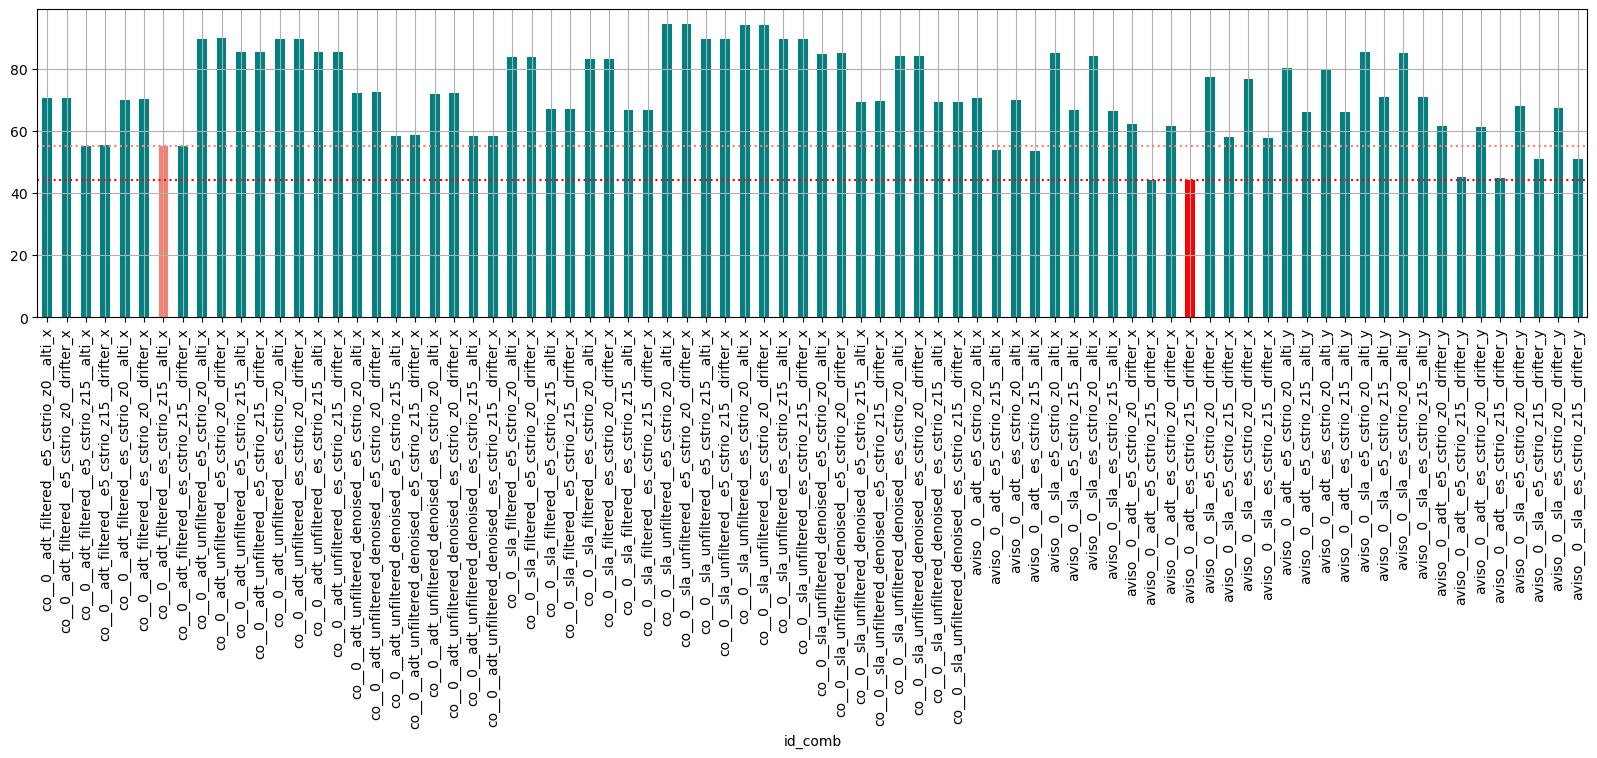

In [39]:
fig = plt.figure(figsize=(20,4))
RSEu_gps.RSE.plot.bar(color=RSEu_gps.color)
plt.axhline(RSE.RSE.loc[min_aviso], color='red', ls=':')
plt.axhline(RSE.RSE.loc[min_co], color='salmon', ls=':')
plt.grid()
print(RSEu_gps.RSE.loc[min_avisou_gps], RSEu_gps.RSE.loc[min_cou_gps])

In [41]:
cluster.close()